In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from matplotlib.lines import Line2D
import pandas as pd
from kaldo.phonons import Phonons
from kaldo.forceconstants import ForceConstants
from kaldo.observables.secondorder import SecondOrder
from kaldo.interfaces.shengbte_io import read_second_order_qe_matrix
from sklearn.neighbors import KernelDensity
from scipy import constants as con
plt.style.use('/home/nwlundgren/spanners/matsci/miscellaneous/mpltstyle.txt')

# Unit conversions
# THz to cm-1
thz_to_invcm = con.value('hertz-inverse meter relationship')*1e12/100


# divide

	#264b96 blue
	#27b376 g1
	#006f3c g2
	#f9a73e y
	#bf212f r

In [24]:
def phonon_getter(potential, fmt='hiphive'):
    forceconstants=ForceConstants.from_folder(
                supercell=(5,5,1),
                folder=potential,
                format=fmt,
                only_second=True)
    phonons=Phonons(forceconstants=forceconstants,
                    is_classic=True,
                    temperature=300,
                    folder=potential+'/ald/',
                    kpts=(5,5,1),
                    third_bandwidth=0.5/4.135)
    return phonons

def cumulative_conductivity(freq, cond, nbins=None, alpha=10):
    if nbins==None:
        nbins = int(freq.max() * alpha)
        print(f'Using {nbins}')
    fbin = np.linspace(freq.min(), freq.max(), nbins)
    return fbin, np.array([(cond[freq<k]).sum() for k in fbin])

In [49]:
layerheight = 25.8/3 #8.6A

# Bilayer Data collection >>>>>>
bic = '#264b96'
bipre = '../inse/classical/bilayer/ald25/25_25_1/'
bilyr_f = np.load(bipre+'/frequency.npy').flatten()
bilyr_v = np.linalg.norm(np.load(bipre+'/velocity.npy'), axis=-1).flatten()
bilyr_ps = np.load('../inse/classical/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/_ps_and_gamma.npy')[:, 0].flatten()
bilyr_bw = np.load('../inse/classical/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/bandwidth.npy').flatten()
bilyr_k = np.load('../inse/classical/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/inverse/conductivity.npy')\
    .diagonal(axis1=1,axis2=2).mean(axis=-1).flatten() * 1.5
bilyr_k *= 51.03/layerheight
bilyr_cf, bilyr_ck = cumulative_conductivity(bilyr_f, bilyr_k,)
print('Bilayer Shapes:', [me.shape for me in [bilyr_f, bilyr_bw, bilyr_ps, bilyr_v, bilyr_k]])

bdosx = np.linspace(bilyr_f.min(), bilyr_f.max()+0.1, 300)
kde = KernelDensity(kernel='gaussian', 
                   bandwidth=0.053, \
                   ).fit(bilyr_f.reshape((-1,1)))
bdosy = np.exp(kde.score_samples(bdosx.reshape((-1,1))))

# Monolayer Data collection >>>>>>>
mic = '#27b376'
mopre = '../inse/classical/monolayer/ald25/25_25_1/'
molyr_f = np.load(mopre+'/frequency.npy').flatten()
molyr_v = np.linalg.norm(np.load(mopre+'/velocity.npy'), axis=-1).flatten()
molyr_ps = np.load('../inse/classical/monolayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/_ps_and_gamma.npy')[:, 0].flatten()
molyr_bw = np.load('../inse/classical/monolayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/bandwidth.npy').flatten()
molyr_k = np.load('../inse/classical/monolayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/inverse/conductivity.npy')\
    .diagonal(axis1=1,axis2=2).mean(axis=-1).flatten() * 1.5
molyr_k *= 50/layerheight
molyr_cf,molyr_ck = cumulative_conductivity(molyr_f, molyr_k,)
print('Monolayer Shapes:', [me.shape for me in [molyr_f, molyr_bw, molyr_ps, molyr_v, molyr_k]])

mdosx = np.linspace(molyr_f.min(), molyr_f.max()+0.1, 300)
kde = KernelDensity(kernel='gaussian', 
                   bandwidth=0.053, \
                   ).fit(molyr_f.reshape((-1,1)))
mdosy = np.exp(kde.score_samples(mdosx.reshape((-1,1))))

# Literature Data
han_lft = np.load('../inse/literaturedata/Han2023-Nanomaterials/lifetime.npy')
han_vel = np.load('../inse/literaturedata/Han2023-Nanomaterials/velocity.npy')
nis_lft = np.load('../inse/literaturedata/Nissimagoudar2017-JCondensMatter/lifetime.npy')

Using 80
Bilayer Shapes: [(15000,), (15000,), (15000,), (15000,), (15000,)]
Using 81
Monolayer Shapes: [(7500,), (7500,), (7500,), (7500,), (7500,)]


/tmp/ipykernel_14141/2288911128.py:47: RuntimeWarning: divide by zero encountered in true_divide
  ax4.scatter(bilyr_f[6:], 1/bilyr_bw[6:], color=bic, s=4, linewidth=4, marker='.', alpha=0.8)


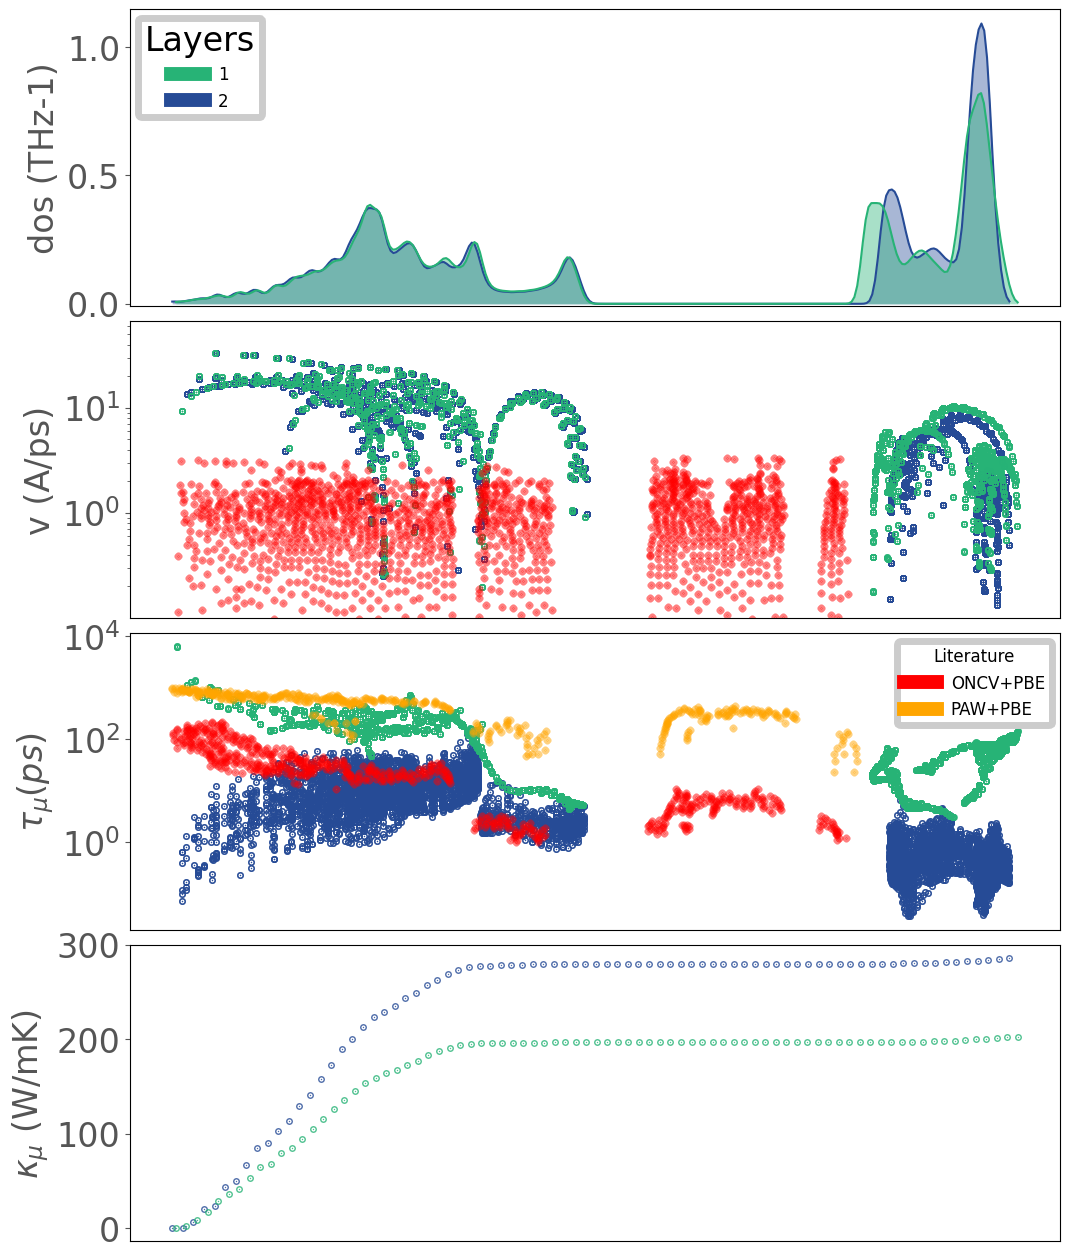

In [60]:
# autocomplete testing area
if None:
    np.load('../inse/MD_input/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/rta/')

# Figure Adjustments >>>>
fig = plt.figure(figsize=(12, 16))
grid = plt.GridSpec(4, 1, wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
#ax3 = fig.add_subplot(grid[2, 0])
ax4 = fig.add_subplot(grid[2, 0])
ax5 = fig.add_subplot(grid[3, 0])
#axes = [ax1, ax2, ax3, ax4, ax5]
axes = [ax1, ax2, ax4, ax5]
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# DoS
ax1.set_ylabel('dos (THz-1)')
ax1.plot(bdosx, bdosy, color=bic)
ax1.fill_between(bdosx, bdosy, 0, color=bic, alpha=0.4, linewidth=0.05)
ax1.plot(mdosx, mdosy, color=mic)
ax1.fill_between(mdosx, mdosy, 0, color=mic, alpha=0.4, linewidth=0.05)
ax1.set_ylim([-0.01, bdosy.max()*1.05])
ax1.set_yticks([0, 0.5, 1.0])

# Velocity
ax2.set_ylabel('v (A/ps)')
ax2.set_yscale('log')
ax2.scatter(bilyr_f, bilyr_v, color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax2.scatter(molyr_f, molyr_v, color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
ax2.scatter(han_vel[0,:], han_vel[1,:], color='r', s=2, linewidth=4, marker='D', alpha=0.5)
ax2.set_ylim([0.1, bilyr_v.max()*2])
ax2.set_yticks([1.0, 10])

# Phase Space
# ax3.set_ylabel(r'$P_{3} (1/rad*ps)$')
# ax3.scatter(bilyr_f, bilyr_ps/(625*225), color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
# ax3.scatter(molyr_f, molyr_ps/(225*225), color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
# ax3.set_ylim([0, .1])
#ax3.set_yticks([0, 0.5, 1.0])

# Bandwidth
ax4.set_ylabel(r'$\tau_{\mu} (ps)$')
ax4.set_yscale('log')
ax4.scatter(bilyr_f[6:], 1/bilyr_bw[6:], color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax4.scatter(molyr_f[6:], 1/molyr_bw[6:], color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
ax4.scatter(han_lft[0,:], han_lft[1,:], color='r', s=2, linewidth=4, marker='D', alpha=0.5)
ax4.scatter(nis_lft[0,:], nis_lft[1,:], color='orange', s=2, linewidth=4, marker='D', alpha=0.5)
#ax3.set_ylim([0, 1])
#ax3.set_yticks([0, 0.5, 1.0])

# Cumulative Conductivity
ax5.set_ylabel(r'$\kappa_{\mu}$ (W/mK)')
ax5.set_yscale('linear')
ax5.scatter(bilyr_cf, bilyr_ck, color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax5.scatter(molyr_cf, molyr_ck, color=mic, s=4, linewidth=4, marker='.', alpha=0.8)

wid = 10
mono = plt.Line2D([],[], color=mic, linewidth=wid)
bi = plt.Line2D([],[], color=bic, linewidth=wid)
han = plt.Line2D([],[], color='r', linewidth=wid)
nis = plt.Line2D([],[], color='orange', linewidth=wid)
ax1.legend([mono,bi,], ['1', '2', ], title='Layers', fontsize=12)
ax4.legend([han,nis], ['ONCV+PBE', 'PAW+PBE'], title='Literature', loc='upper right', fontsize=12, title_fontsize=12)


Text(0.5, 1.0, 'InSe Monolayer - Dispersion')

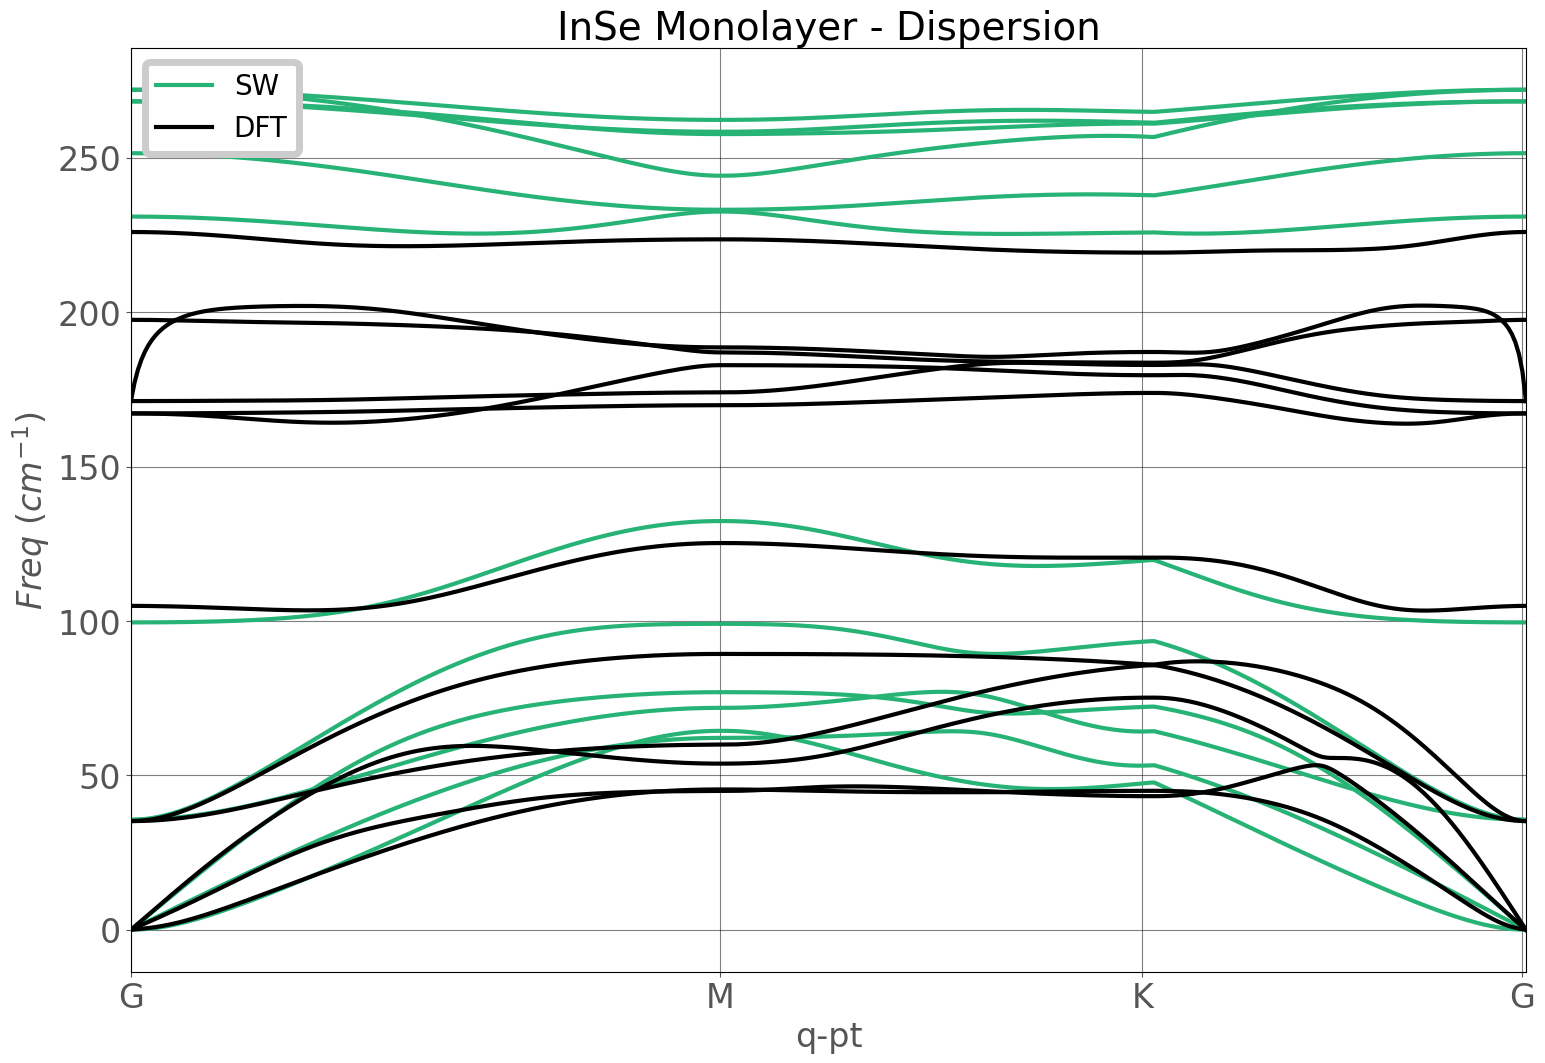

In [31]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot()
#xaxis = np.loadtxt('../inse/classicalmd/monolayer/path.out.txt')[:, :3]
xaxis = np.linspace(0,1,399)
d3path = '../inse/vdw-d3/monolayer/dynamics/FREQ.gp'
emppath = '../inse/classical/monolayer/'


velocity_emp = np.loadtxt(emppath+'kaldo.out.vels.gp')
frequency_dft = np.loadtxt(d3path)[:, 1:]

frequency_emp = np.loadtxt(emppath+'kaldo.out.freq.gp')[:, 1:]
ax.plot(xaxis, frequency_emp, color=mic, linewidth=3, label='SW')
ax.plot(xaxis, frequency_dft, color='k', linewidth=3, label='PBE')
ax.set_xticks([0, 169/400, 290/400, 399/400], ['G', 'M', 'K', 'G'])
ax.grid(axis='both', color='k', alpha=1/2)

lines = [Line2D([], [], color=mic, linewidth=3), Line2D([], [], color='k', linewidth=3)]
labels = ['SW', 'DFT']
ax.legend(lines, labels, loc='upper left')

ax.set_xlim([0,1])
ax.set_ylabel(r'$Freq\ (cm^{-1})$')
ax.set_xlabel('q-pt')

ax.set_title('InSe Monolayer - Dispersion')
#ax.set_ylim([0, 100])
#ax.set_title('InSe Monolayer - Dispersion (low freq)')


# lab.append(system)

Text(0.5, 1.0, 'InSe Phonon Dispersion')

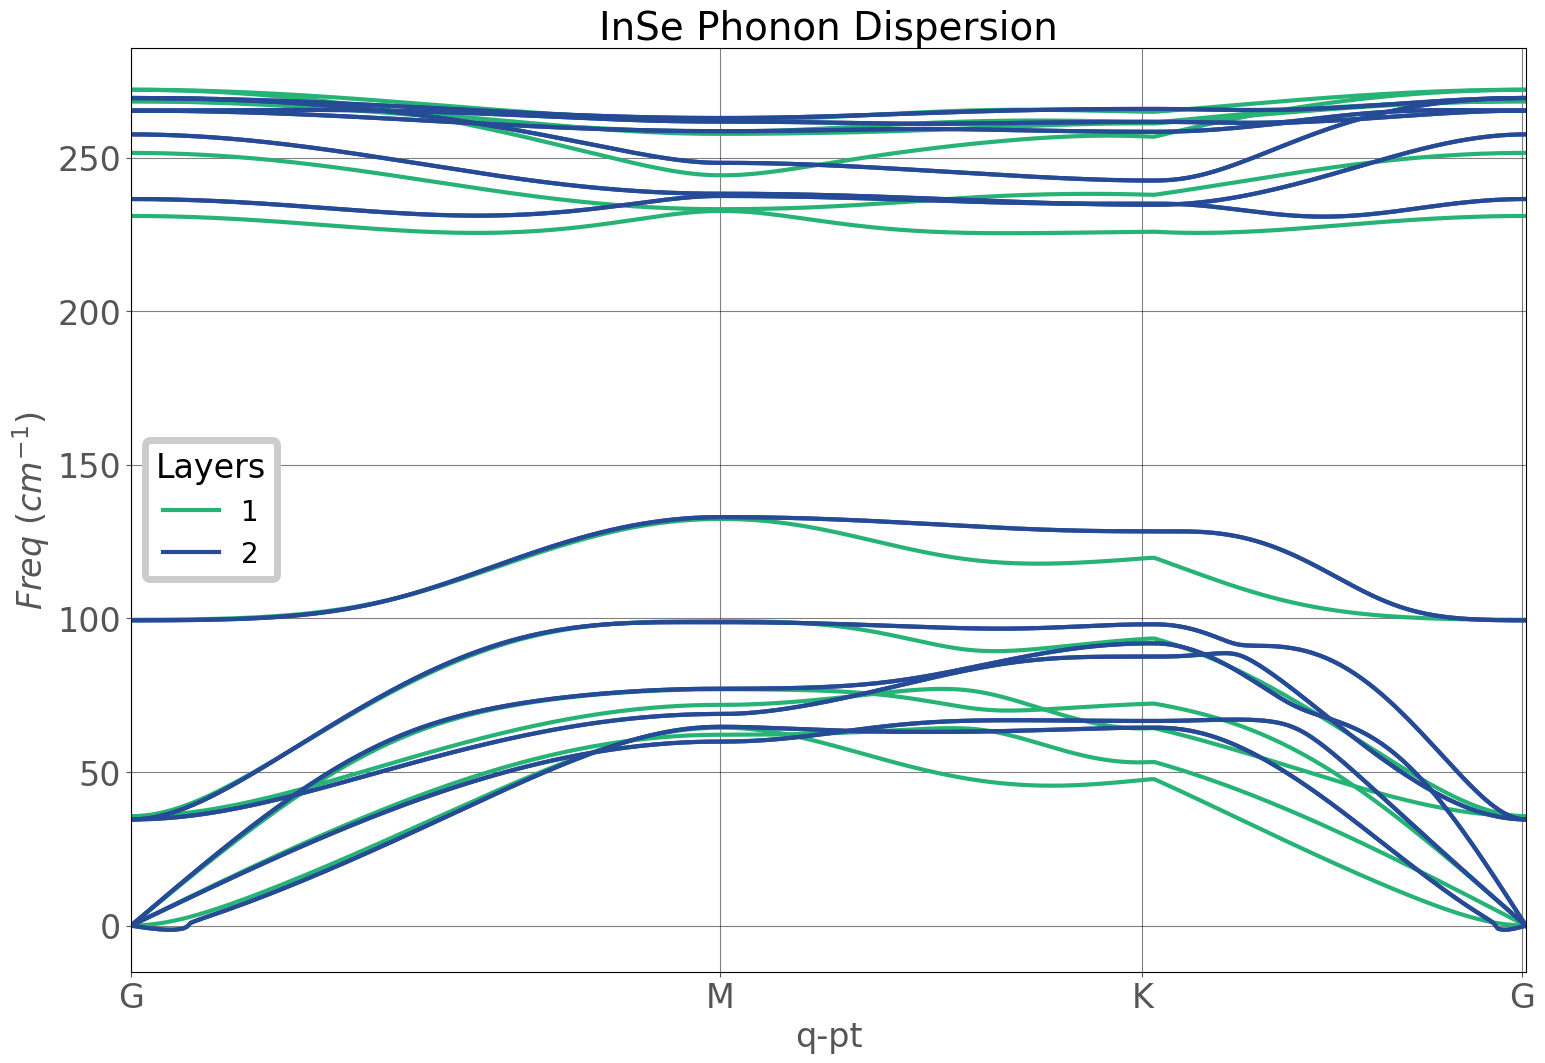

In [30]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot()
#xaxis = np.loadtxt('../inse/classicalmd/monolayer/path.out.txt')[:, :3]
xaxis = np.linspace(0,1,399)

mono = np.loadtxt('../inse/classical/monolayer/kaldo.out.freq.gp')[:, 1:]
bi = np.loadtxt('../inse/classical/bilayer/kaldo.out.freq.gp')[:, 1:]

ax.plot(xaxis, mono, color=mic, linewidth=3, label='SW')
ax.plot(xaxis, bi, color=bic, linewidth=3, label='PBE')
ax.set_xticks([0, 169/400, 290/400, 399/400], ['G', 'M', 'K', 'G'])
ax.grid(axis='both', color='k', alpha=1/2)

lines = [Line2D([], [], color=mic, linewidth=3), Line2D([], [], color=bic, linewidth=3)]
labels = ['1', '2']
ax.legend(lines, labels, loc='center left', title='Layers')

ax.set_xlim([0,1])
ax.set_ylabel(r'$Freq\ (cm^{-1})$')
ax.set_xlabel('q-pt')

ax.set_title('InSe Phonon Dispersion')
#ax.set_ylim([0, 100])
#ax.set_title('InSe Monolayer - Dispersion (low freq)')


# lab.append(system)

In [129]:
bilyr_f[np.argwhere((bilyr_f>4))].min()

6.918562286096532

In [ ]:
# Indium Selenide
Plots to generate
- add up the bulk to my lattice dynamics plot
- make the HE convergence plot

# Amorphous Carbon


In [4]:
hac = np.load('../inse/generation_3/fullerite/plotdata/hac.npy')
fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(4, 1, wspace=0.3, hspace=0.2)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
ax4 = fig.add_subplot(grid[3, :])
axes = [ax1, ax2, ax3, ax4]
dnorms = Normalize(vmin=2, vmax=fullerite['den'].max())
jet = cm.get_cmap('jet')

#dnorms = Normalize(vmin=2, vmax=fullerite['den'].max())
#jet = cm.get_cmap('jet')
#divider = make_axes_locatable(ax1)
#cax = divider.new_horizontal(size='5%', pad=0.8, pack_start=False)
#cax.yaxis.set_label_position('right')
#cax.yaxis.tick_right()
#fig.add_axes(cax)
#fig.colorbar(cm.ScalarMappable(norm=dnorms, cmap=jet), cax=cax)
#cax.set_xticks([])
#cax.set_yticks([2.0, 2.5, 3.0, 3.5])
#cax.set_ylabel('Density (g/cm3)')

for ax, model in zip(axes, hac):
    color = jet(dnorms(model['density']))
    stdhac = model['stdhac']
    meanhac = model['meanhac']
    hacbar = meanhac.mean(axis=-1)
    hp = hacbar+stdhac
    hm = hacbar-stdhac
    tau = np.arange(stdhac.size) * model['dtfs'] / 1000
    
    ax.plot(tau, meanhac[:, 0], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, meanhac[:, 1], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, meanhac[:, 2], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, hacbar, color=color, alpha=1)
    #ax.plot(tau, hp, color=color, alpha=0.8)
    #ax.plot(tau, hm, color=color, alpha=0.8)
    ax.fill_between(tau, hm, hp, color=color, alpha=0.3)

for ax in axes:
    ax.set_ylim([-5, 5])
    ax.set_xlim([5e-3, 250])
    ax.set_xscale('log')
    ax.set_ylabel('HFACF', fontsize=14)

ax4.set_xlabel('Correlation time (ps)')

FileNotFoundError: [Errno 2] No such file or directory: '../inse/generation_3/fullerite/plotdata/hac.npy'